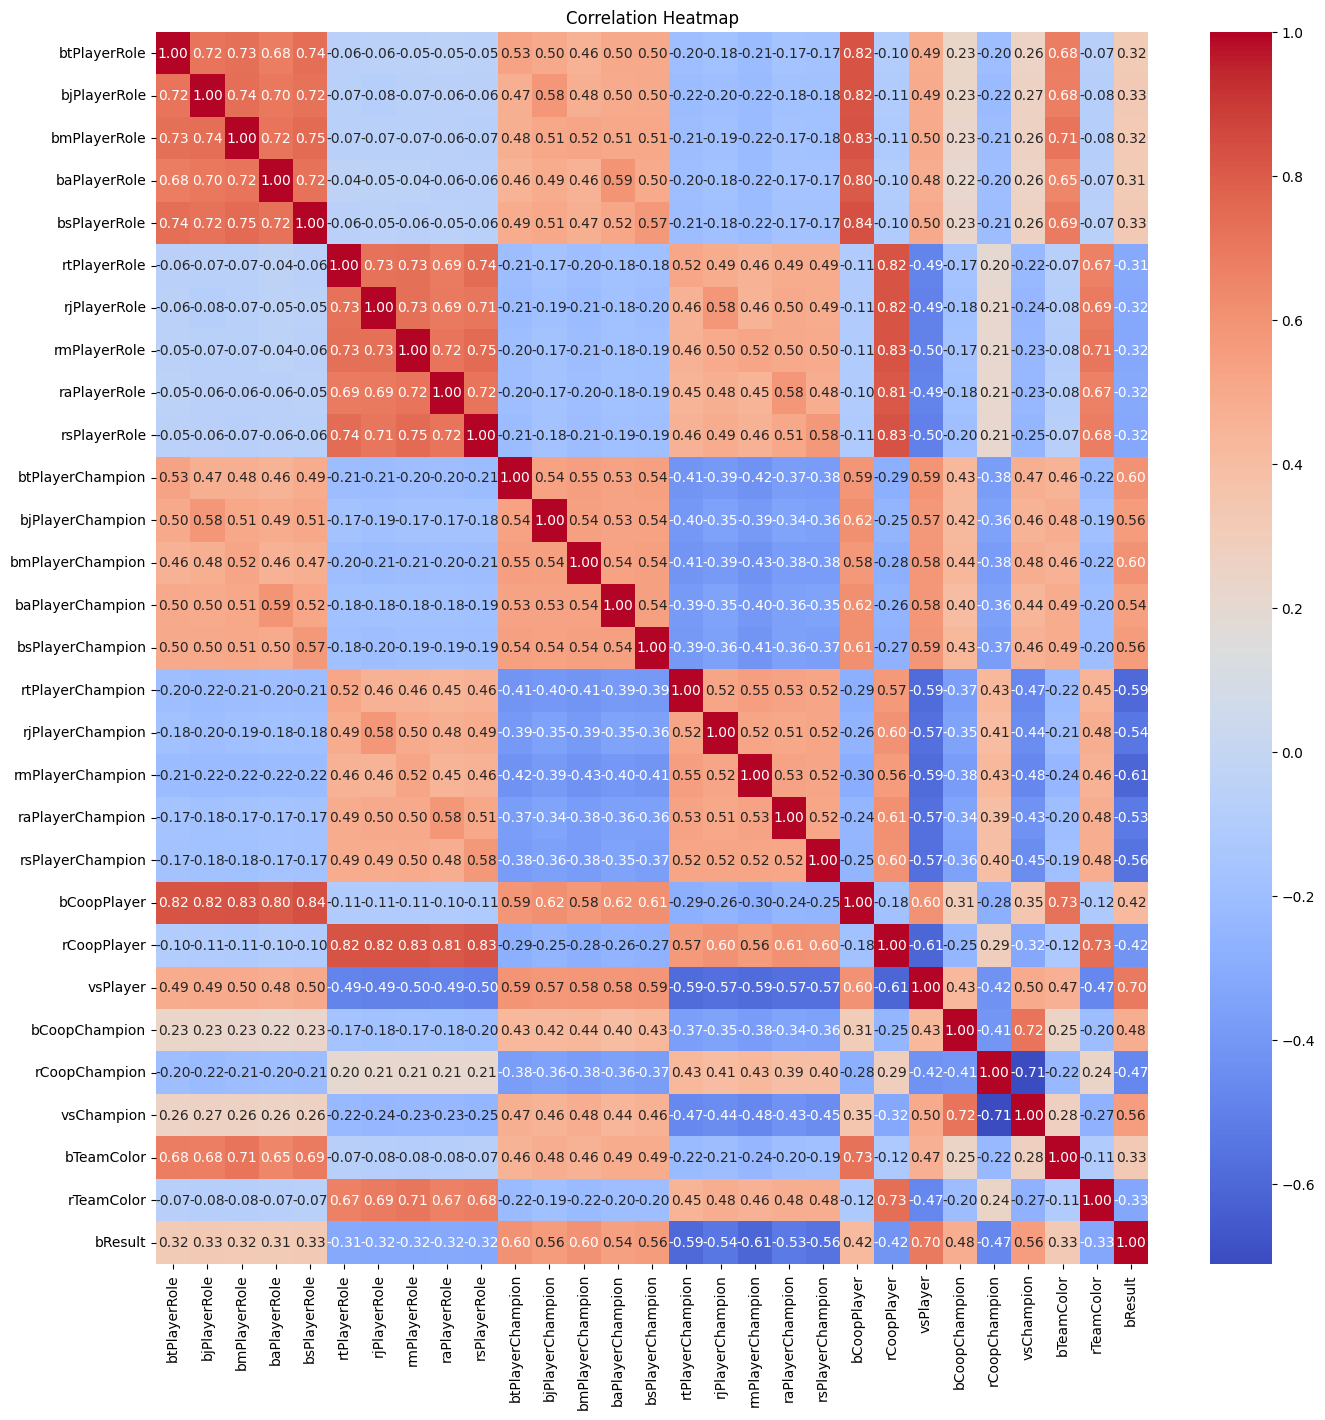

Features with high correlation to the target:
 bResult             1.000000
vsPlayer            0.698907
rmPlayerChampion    0.608310
btPlayerChampion    0.603913
bmPlayerChampion    0.602946
rtPlayerChampion    0.592449
bsPlayerChampion    0.564752
bjPlayerChampion    0.560847
vsChampion          0.556289
rsPlayerChampion    0.555020
rjPlayerChampion    0.541690
baPlayerChampion    0.538911
raPlayerChampion    0.530289
bCoopChampion       0.484737
rCoopChampion       0.473726
bCoopPlayer         0.417016
rCoopPlayer         0.416028
bTeamColor          0.327004
rTeamColor          0.325964
bsPlayerRole        0.325826
bjPlayerRole        0.325583
rsPlayerRole        0.322525
bmPlayerRole        0.319954
rmPlayerRole        0.318536
rjPlayerRole        0.318509
btPlayerRole        0.316537
raPlayerRole        0.315693
baPlayerRole        0.314709
rtPlayerRole        0.311653
Name: bResult, dtype: float64


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgbStack
import pandas as pd

from sklearn.model_selection import cross_val_score


import load_data

modelInstance = xgbStack.xgbStack()
match_df_train = modelInstance.import_data(True, bGenerateOutputFile=False)
match_df_test = modelInstance.import_data(False, bGenerateOutputFile=False)

x_train, y_train = modelInstance.extract_labels(match_df_train)
x_test, y_test = modelInstance.extract_labels(match_df_test)    

x_combined = pd.concat([x_train, x_test])
y_combined = pd.concat([y_train, y_test])
df_combined = x_combined.copy()
df_combined['bResult'] = y_combined

correlation_matrix = df_combined.corr()
plt.figure(figsize=(16, 16)) #Adjust width and height of image.
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size" : 10})
plt.title("Correlation Heatmap")
plt.show()

# Check for high correlations with target
high_corr_features = correlation_matrix['bResult'].abs().sort_values(ascending=False)
print("Features with high correlation to the target:\n", high_corr_features)


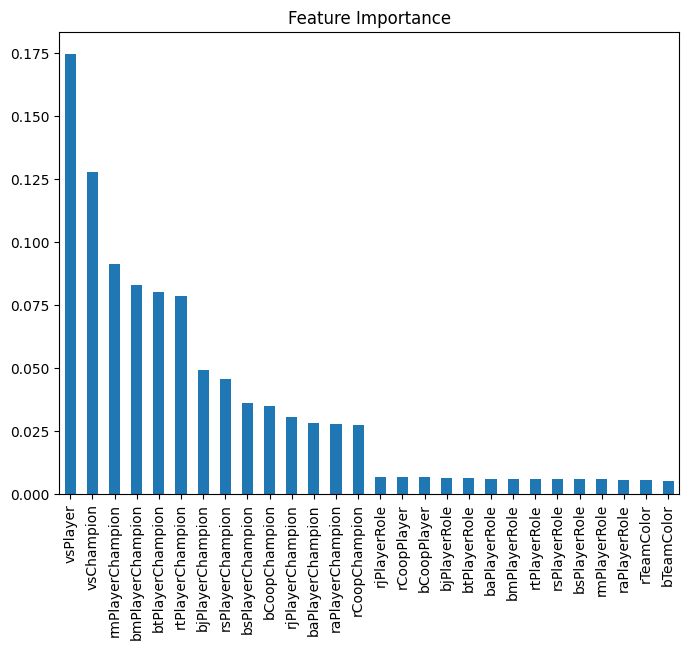

Feature Importance:
 vsPlayer            0.174702
vsChampion          0.127791
rmPlayerChampion    0.091246
bmPlayerChampion    0.082896
btPlayerChampion    0.080184
rtPlayerChampion    0.078687
bjPlayerChampion    0.049354
rsPlayerChampion    0.045795
bsPlayerChampion    0.035913
bCoopChampion       0.034813
rjPlayerChampion    0.030696
baPlayerChampion    0.028070
raPlayerChampion    0.027733
rCoopChampion       0.027381
rjPlayerRole        0.006902
rCoopPlayer         0.006854
bCoopPlayer         0.006566
bjPlayerRole        0.006373
btPlayerRole        0.006249
baPlayerRole        0.006108
bmPlayerRole        0.006054
rtPlayerRole        0.006009
rsPlayerRole        0.005838
bsPlayerRole        0.005790
rmPlayerRole        0.005765
raPlayerRole        0.005522
rTeamColor          0.005442
bTeamColor          0.005268
dtype: float64


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model_rfc = RandomForestClassifier(random_state=42)
model_rfc.fit(x_train, y_train)

feature_importance = pd.Series(model_rfc.feature_importances_, index=x_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='bar')
plt.title("Feature Importance")
plt.show()

print("Feature Importance:\n", feature_importance)

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score

#Note: Commented lines denote that they WILL be included in the 'no leak' dataset.
list_dropcol = [    
    # 'btPlayerRole', 
    # 'bjPlayerRole', 
    # 'bmPlayerRole',       
    # 'baPlayerRole', 
    # 'bsPlayerRole',     
    # 'rtPlayerRole', 
    # 'rjPlayerRole',
    # 'rmPlayerRole', 
    # 'raPlayerRole', 
    # 'rsPlayerRole', 
    'btPlayerChampion',
    'bjPlayerChampion', 
    'bmPlayerChampion', 
    'baPlayerChampion',
    'bsPlayerChampion', 
    'rtPlayerChampion', 
    'rjPlayerChampion',
    'rmPlayerChampion', 
    'raPlayerChampion', 
    'rsPlayerChampion',
    'bCoopPlayer', 
    'rCoopPlayer', 
    'vsPlayer', 
    'bCoopChampion',
    'rCoopChampion', 
    'vsChampion', 
    'bTeamColor', 
    'rTeamColor'
]    


x_train_no_leak = x_train.drop(columns=list_dropcol)
x_test_no_leak = x_test.drop(columns=list_dropcol)

model_nb = GaussianNB()
model_nb_no_leak = GaussianNB()

model_nb.fit(x_train, y_train)
model_nb_no_leak.fit(x_train_no_leak, y_train)

x_combined_no_leak = pd.concat([x_train_no_leak, x_test_no_leak])

# Evaluate both models
y_pred = model_nb.predict_proba(x_test)[:, 1]
y_pred_no_leak = model_nb_no_leak.predict_proba(x_test_no_leak)[:, 1]

auc_with_leak = roc_auc_score(y_test, y_pred)
auc_without_leak = roc_auc_score(y_test, y_pred_no_leak)

print(f"AUC with leaky feature: {auc_with_leak:.4f}")
print(f"AUC without leaky feature: {auc_without_leak:.4f}")



AUC with leaky feature: 1.0000
AUC without leaky feature: 0.8825


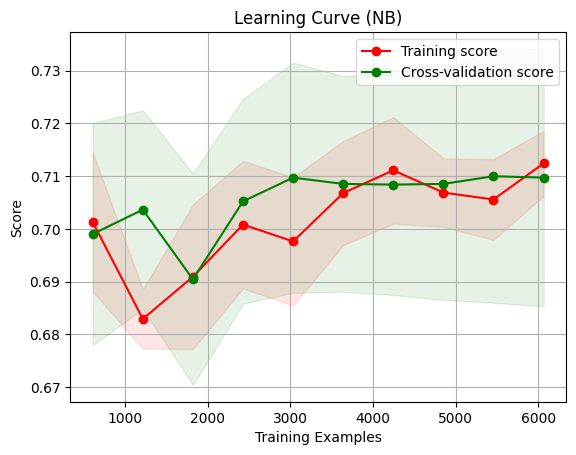

In [16]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model_nb_no_leak, x_combined_no_leak, y_combined, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title("Learning Curve (NB)")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

# Plot the fill between for standard deviation
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r"
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g"
)

# Plot the mean training and test scores
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean,  'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()